In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit import BasicAer

# Quantum parallelism (Deutsch's algorithm)

## Problem statement

The Deutsch-Jozsa algorithm is one of the earliest examples of a quantum algorithm providing an exponential speed-up compared to the best classical algorithm. The problem it solves is very contrived, but it is a good example of how quantum computers can be used to solve problems in a completely different way than classical computers.

The problem is defined as follows. We are given a function $f:\{0,1\}\rightarrow\{0,1\}$, which takes as input a bit, and returns either $0$ or $1$. We are promised that the function is either constant (returns the same value for all inputs), or balanced (returns $0$ for exactly half of all inputs, and $1$ for the other half). The task is to determine whether the function is constant or balanced by making as few function evaluations as possible.

## The classical solution

The best classical algorithm to solve this problem is to evaluate the function for $2$ different inputs. If all of these evaluations return the same value, then we know that the function is constant. Otherwise, it must be balanced.

## The quantum solution

The quantum solution to this problem uses the Deutsch's algorithm. It uses $2$ qubits, initialized to the state $|0\rangle|1\rangle$. The first qubit is used as input to the function $f$, and the last qubit is used as an output qubit, which is flipped depending on the output of the function. The algorithm then performs a series of quantum gates, and finally measures the output qubit. The quantum circuit for the algorithm is shown below.

![Deutsch's algorithm](../images/Deutsch.png)

# Utils

In [3]:
def execute_circuit(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def count_to_prob(counts):
    shots = sum(counts.values())
    n_qubits = len(list(counts.keys())[0])
    probs = np.zeros(2**n_qubits)
    for key, value in counts.items():
        probs[int(key, 2)] = value/shots
    return probs

# Qiskit Implementation

## Oracle

Considering the solution of the Deutsch's algorithm, with a single qubit. 

The algorithm starts by having an ancilla qubit in the state $|1\rangle$ and the input qubit in the state $|0\rangle$. Then, the ancilla qubit is prepared in the sate $|-\rangle$ by applying a Hadamard gate. The input qubit is then prepared in the state $|+\rangle$ by applying a Hadamard gate, this sate is an equal superposition of $|0\rangle$ and $|1\rangle$.

$$ |0\rangle \xrightarrow{H} \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \$$

Then, the function $f(x)$ is applied such that the state $\ket{x}$ obtains a phase of $(-1)^{f(x)}$.

$$ \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \xrightarrow{f(x)} \frac{1}{\sqrt{2}}((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle) \$$

To apply this pahse it is used an anclidary qubit in the state $|-\rangle$ such that the Oracle $U_f$ is defined as:

$$ U_f \ket{x}\otimes\ket{y} = \ket{x}\otimes\ket{y \oplus f(x)} $$
Then,
$$ U_f \ket{x}\otimes\ket{-} = (-1)^{f(x)} \ket{x}\otimes\ket{-} $$


The oracle for example for the constant function $f(x) = 0$:

$$ U_f \ket{x}\otimes\ket{-} = \ket{x}\otimes\ket{-} $$
$$ U_f = I \otimes I $$

for the constant function $f(x) = 1$:

$$ U_f \ket{x}\otimes\ket{-} = -1 \ket{x}\otimes\ket{-} $$
$$ U_f = I \otimes X $$

for the balanced function $f(x) = x$:

$$ U_f \ket{x}\otimes\ket{-} = (-1)^x \ket{x}\otimes\ket{-} $$
$$ U_f = CNOT $$

for the balanced function $f(x) = \overline{x}$:

$$ U_f \ket{x}\otimes\ket{-} = (-1)^{1-x} \ket{x}\otimes\ket{-} $$
$$ U_f = (I\otimes X) \cdot CNOT$$

Then, the total algorithm looks like:

$$ U_f\ket{+}\otimes\ket{-} = \frac{1}{\sqrt{2}}((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle)\otimes\ket{-} $$

if $f(x)$ is constant, then the final state is:

$$ \ket{+}\otimes\ket{-} \xrightarrow{H} \ket{0}\otimes\ket{-} $$

Always the qubit is measured in the state $|0\rangle$ when the function is constant. If the function is balanced, then the final state is:

$$ \ket{-}\otimes\ket{-} \xrightarrow{H} \ket{1}\otimes\ket{-} $$

The qubit is always measured in the state $|1\rangle$ when the function is balanced.


In [7]:
def Oracle(balanced=1, value=1):
    qc = QuantumCircuit(2)
    if balanced:
        qc.cx(0,1)
    if value:
        qc.x(1)
    oracle_gate = qc.to_gate()
    oracle_gate.name = f'Oracle\nBalanced' if balanced else f'Oracle\nConstant'
    return oracle_gate

Oracle
Balanced


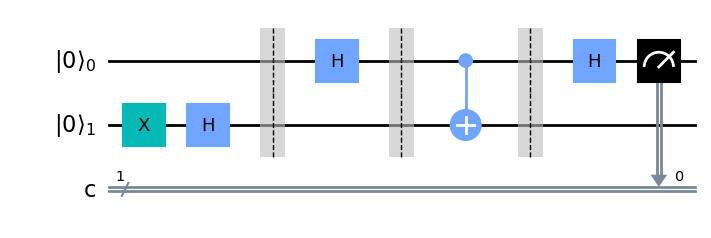

In [12]:
n_qubits = 1    # Number of qubits
n_ancillas = 1  # Number of ancilla qubits

# Create a quantum circuit on n_qubits and n_ancillas qubits

qr = QuantumRegister(n_qubits + n_ancillas, r'|0\rangle')
cr = ClassicalRegister(n_qubits, 'c')
qc = QuantumCircuit(qr, cr)

q_ancillas = qr[n_qubits:]
q_qubits = qr[:n_qubits]

# Initialize the ancilla qubit in the |-⟩ state
qc.x(q_ancillas)
qc.h(q_ancillas)
qc.barrier()

# Apply the Hadamard gate to the qubits
qc.h(q_qubits)
qc.barrier()

# Apply the Oracle
balanced = np.random.randint(2)
value = np.random.randint(2)
oracle_gate_name = f'Oracle\nBalanced' if balanced else f'Oracle\nConstant'
print(oracle_gate_name)
qc.append(Oracle(balanced, value), qr)

qc.barrier()
# Apply the Hadamard gate to the qubits
qc.h(q_qubits)

# Measure the qubits
qc.measure(q_qubits, cr)

# Draw the circuit
qc.decompose(gates_to_decompose = oracle_gate_name).draw(output='mpl')


# Run the quantum circuit on a simulator

[1. 0.]


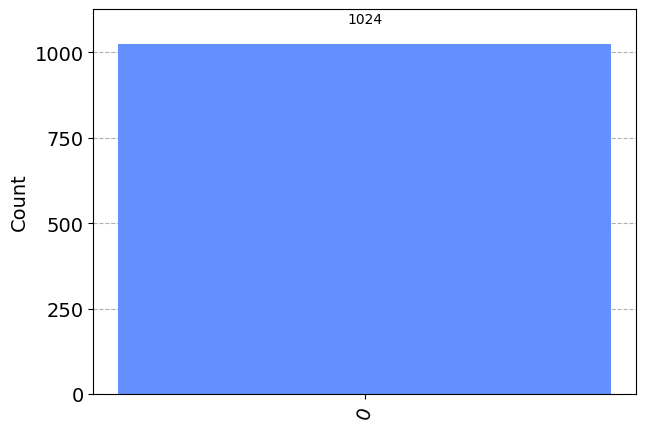

In [ ]:
counts = execute_circuit(qc)
print(count_to_prob(counts))

plot_histogram(counts)

# Quantum Teleportation

## Problem statement

The task is to implement a quantum circuit that can transfer the state of one qubit to another qubit, through teleportation. The circuit should teleport the state 
$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$ 
from Alice's qubit to Bob's qubit.

## The step by step solution

1. Alice and Bob share a pair of entangled qubits.
2. Alice wants to send the state $|\psi\rangle$ to Bob.
3. Alice makes some local changes to her qubit, and then measures both her qubits. She classically communicates the results of her measurements to Bob.
4. Bob, knowing the results of Alice's measurements, performs some operations on his qubit to get the state $|\psi\rangle$.

### The entangled pair
$$\ket{0}_A\ket{0}_B \xrightarrow{Bell State} \ket{\Phi^+} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$$

### Alice's operations
$$ \ket{\psi}\ket{\Phi^+} \xrightarrow{CNOT\otimes I} \frac{1}{\sqrt 2}\left(\alpha\ket{0}_A\ket{0}_A\ket{0}_B + \alpha\ket{0}_A\ket{1}_A\ket{1}_B + \beta\ket{1}_A\ket{1}_A\ket{0}_B + \beta\ket{1}_A\ket{0}_A\ket{1}_B\right) $$

$$\xrightarrow{H \otimes I\otimes I} \frac{1}{2}\left( \alpha\ket{0}_A\ket{0}_A\ket{0}_B + \alpha\ket{0}_A\ket{1}_A\ket{1}_B + \alpha\ket{1}_A\ket{0}_A\ket{0}_B + \alpha\ket{1}_A\ket{1}_A\ket{1}_B + \beta\ket{0}_A\ket{0}_A\ket{1}_B + \beta\ket{0}_A\ket{1}_A\ket{0}_B - \beta\ket{1}_A\ket{0}_A\ket{1}_B - \beta\ket{1}_A\ket{1}_A\ket{0}_B \right)$$

### Rearranging the qubits
$$= \frac{1}{2}\left( \ket{00}_A\ket{\psi} + \ket{01}_A\sigma_x\ket{\psi} + \ket{10}_A\sigma_z\ket{\psi} + \ket{11}_A\sigma_x\sigma_z\ket{\psi} \right)$$

# Qiskit Implementation

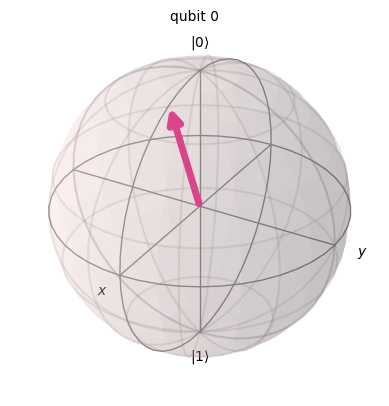

In [ ]:
# Prepare a random input state
input_state = np.random.rand(2**n_qubits)
input_state = input_state/np.linalg.norm(input_state)

# Initialize the qubit
init_gate = Initialize(input_state)

# Plot the state vector in the Bloch sphere
plot_bloch_multivector(input_state)

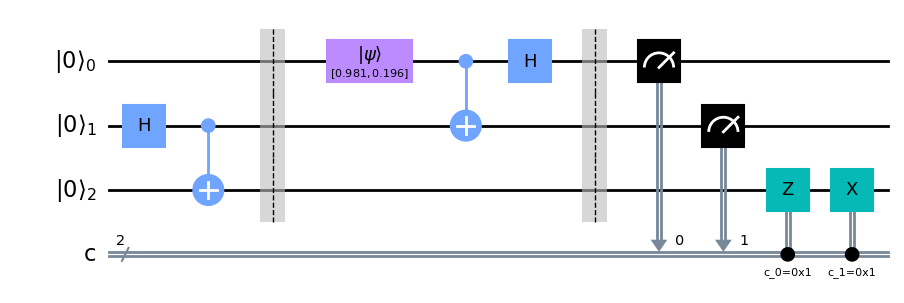

In [ ]:
q_r = QuantumRegister(3, r'|0\rangle')
c_r = ClassicalRegister(2, 'c')

qc = QuantumCircuit(q_r, c_r)

Alce_qubits = q_r[0:2]
Bob_qubits = q_r[2:3]

# Alice and Bob share an entangled pair of qubits

qc.h(Alce_qubits[1])
qc.cx(Alce_qubits[1], Bob_qubits)
qc.barrier()

# Alice encodes her message in her qubit
qc.append(init_gate, [Alce_qubits[0]])

qc.cx(Alce_qubits[0], Alce_qubits[1])
qc.h(Alce_qubits[0])
qc.barrier()

# Alice measures her qubits

qc.measure(Alce_qubits, c_r)

# Alice sends her measurement to Bob

qc.z(Bob_qubits).c_if(c_r[0], 1)
qc.x(Bob_qubits).c_if(c_r[1], 1)

# Draw the circuit
qc.draw(output='mpl')

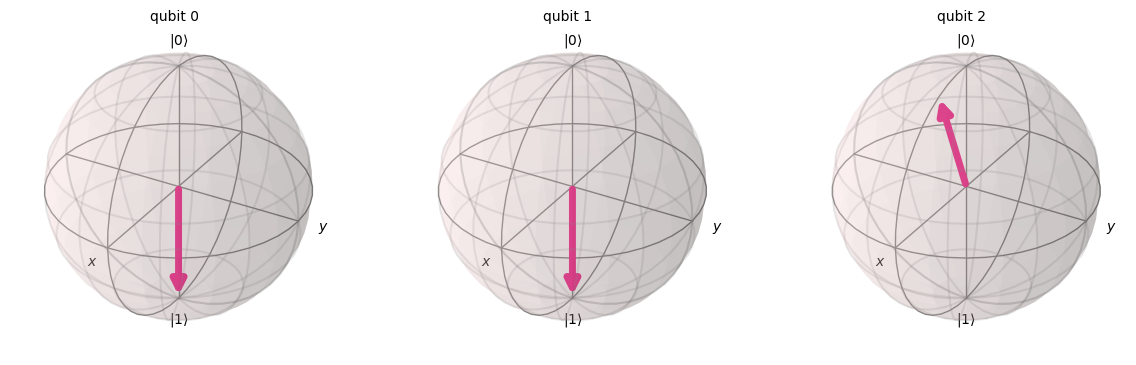

In [ ]:
# Measure the state of Bob's qubit. State vector
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
state = job.result().get_statevector(qc)

# Plot the state vector in the Bloch sphere
plot_bloch_multivector(state)

# Bernstein-Vazirani algorithm

## Problem statement

The Bernstein-Vazirani algorithm is another example of a quantum algorithm providing an exponential speed-up compared to the best classical algorithm. The problem is a good example of how quantum computers can be used to solve problems in a completely different way than classical computers.

The problem is defined as follows. We are given a function $f:\{0,1\}^n\rightarrow\{0,1\}$,

$$ f(x) = s \cdot x \pmod{2} $$

where $x$ is an $n$-bit string, and $s$ is an unknown $n$-bit string. The task is to find the string $s$ by making as few function evaluations as possible.

[Qiskit Reference](https://learn.qiskit.org/course/ch-algorithms/bernstein-vazirani-algorithm)
